Suppose $G$ has a vertex $v$ of degree one. We can remove the edge at $v$ without affecting planarity. Likewise if $G$ has a vertex $v$ of degree two, with edges $uv$ and $vw$, then we can remove these two edges, adding the edge $uw$ if it is not already present. This does not affect planarity either.

Repeating such operations maximally, we arrive at the core $G^*$ of $G$, in which each vertex has degree zero or at least three. (Possibly $G^*$ has no edges.) The labels of the vertices in $G^*$ can depend on the order in which the operations are done but modulo this, $G^*$ is determined by $G$. Hence we need not worry about the order of the operations.


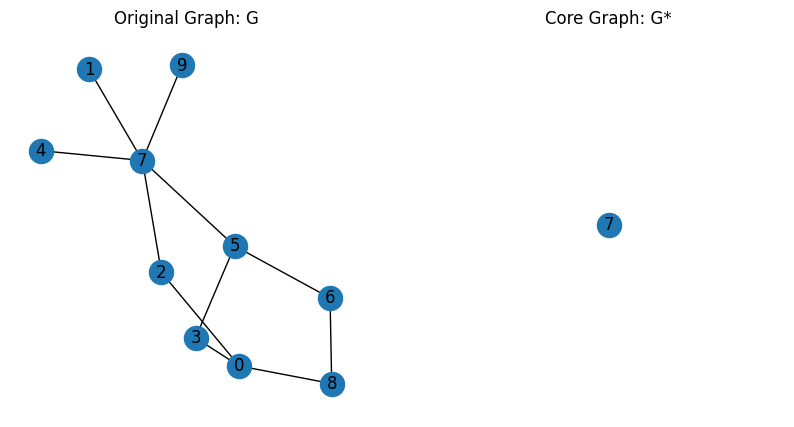

Original nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Original edges: [(0, 2), (0, 3), (0, 8), (1, 7), (2, 7), (3, 5), (4, 7), (5, 6), (5, 7), (6, 8), (7, 9)]
Core nodes: [7]
Core edges: []


In [53]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque

def find_core(graph):
    '''
    Finds the core G* of a graph G by repeatedly removing vertices of
    degree one and suppressing vertices of degree two.
    Args:
        graph: The input graph.
    Returns:
        The core of the graph.
    '''
    # Work on a copy to avoid modifying the original graph
    g_core = graph.copy()

    # Use a queue to keep track of vertices that might need reduction.
    # Initialise it with all vertices of degree 1 or 2.
    q = deque([node for node in g_core.nodes() if g_core.degree(node) in [1, 2]])

    while q:
        v = q.popleft()

        # The vertex might have been removed or its degree might have changed
        # since it was added to the queue, so we re-check.
        if v not in g_core or g_core.degree(v) not in [1, 2]:
            continue

        # Degree 1 reduction
        if g_core.degree(v) == 1:
            # Get the single neighbour before removing v
            neighbour = list(g_core.neighbors(v))[0]
            g_core.remove_node(v)

            # The neighbour's degree has now decreased. If it's now 1 or 2,
            # it becomes a candidate for reduction.
            if neighbour in g_core and g_core.degree(neighbour) in [1, 2]:
                q.append(neighbour)

        # Degree 2 reduction
        elif g_core.degree(v) == 2:
            # Get the two neighbours before removing v
            u, w = list(g_core.neighbors(v))
            g_core.remove_node(v)

            # Add the shortcut edge if the neighbours are not the same and
            # not already connected.
            if u != w and not g_core.has_edge(u, w):
                g_core.add_edge(u, w)

            # The degrees of the neighbours might have changed. Check if they
            # are now candidates for reduction.
            if u in g_core and g_core.degree(u) in [1, 2]:
                q.append(u)
            if w in g_core and g_core.degree(w) in [1, 2]:
                q.append(w)

    return g_core


# Create a random graph
G_demo = nx.gnp_random_graph(10, 0.25)
G_core_demo = find_core(G_demo)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
nx.draw(G_demo, with_labels=True)
plt.title("Original Graph: G")
plt.subplot(1, 2, 2)
nx.draw(G_core_demo, with_labels=True)
plt.title("Core Graph: G*")

plt.show()

print("Original nodes:", G_demo.nodes())
print("Original edges:", G_demo.edges())
print("Core nodes:", G_core_demo.nodes())
print("Core edges:", G_core_demo.edges())

A graph where every vertex has a degree of at least two is guaranteed to contain a cycle. A way to find one is with a depth-first search (DFS).

1.  Start at any vertex $v_0$ in the graph.
2.  Build a path by repeatedly moving to an unvisited neighbor:
    *   From vertex $v_i$, choose a neighbour that has not been visited yet.
    *   Move to it and mark it as visited.
    *   Continue building the path $v_0, \dots, v_k$.
3.  Eventually, we must revisit a vertex:
    *   Since every vertex has degree at least $2$, each vertex (except possibly the starting point) has at least exit edge (aside from the entry).
    *   Eventually, we reach a vertex $v_k$ that has no unvisited neighbors
    *   Again, as the degree of this vertex is at least $2$, there must be at least one other edge which leads to a previously visited vertex $v_j$
4.  Extract the cycle $v_j, \dots v_k, v_j$.

A chord of a cycle $C$ is an edge connecting two non-adjacent vertices of $C$. In a graph with a minimum degree of at least three, we can guarantee finding a cycle that has a chord.

1.  Find any cycle $C$ using the procedure above.
2.  Check if $C$ has a chord:
    *   For each vertex $v \in C$, check if $v$ has edges to non-adjacent vertices in $C$.
    *   If yes, then a cycle with a chord has been found.
3.  If C has no chord, then we extend the cycle:
    *   Since every vertex has degree at least $3$, and each vertex in $C$ uses $2$ edges for the cycle, every vertex in $C$ has at least one edge leading outside $C$
    *   Pick any vertex $v \in C$ and follow an edge to a vertex outside $C$. Build a path from $v$ using DFS.
    *   If we reach a neighbour $w$ that is in the original cycle but is not $v$, then we have a potential chord.
    *   Form the cycle $C'$ using the path from $v$ to $w$, then using the segment from the original cycle back to $v$.
4. The new cycle starts and ends at $v$ and contains the chord $vw$.

In [54]:
def find_cycle(graph):
    '''
    Find a cycle in a graph with minimum degree at least 2.
    Args:
        A graph with minimum degree >= 2
    Returns:
        A list of vertices forming a cycle, or None if no cycle exists
    '''
    if len(graph) == 0:
        return None

    # Start at any vertex
    start = next(iter(graph.nodes()))
    visited = {start}
    path = [start]

    current = start

    while True:
        # Find an unvisited neighbour
        unvisited_neighbours = [n for n in graph.neighbors(current) if n not in visited]

        if unvisited_neighbours:
            # Move to an unvisited neighbour
            next_vertex = unvisited_neighbours[0]
            visited.add(next_vertex)
            path.append(next_vertex)
            current = next_vertex
        else:
            # No unvisited neighbours - must have a neighbour in the path
            # Find where we connect back to the path
            for neighbour in graph.neighbors(current):
                if neighbour in path:
                    # Found the cycle
                    cycle_start_idx = path.index(neighbour)
                    cycle = path[cycle_start_idx:] + [neighbour]
                    return cycle

            # This shouldn't happen in a connected graph with min degree 2
            return None

In [55]:
def find_cycle_with_chord(graph):
    '''
    Find a chorded cycle in a graph with minimum degree 3.
    Args:
        G: A graph with minimum degree >= 3
    Returns:
        (cycle, chord) where cycle is a list of nodes forming a cycle and
        chord is a tuple (u, v) representing the chord edge
        None: If no chorded cycle is found
    '''
    # Verify minimum degree constraint
    if min(dict(graph.degree()).values()) < 3:
        raise ValueError("Graph must have minimum degree of at least 3")

    # Try each starting node
    for start in graph.nodes():
        # BFS to explore all paths from start
        # State: (current_node, path_nodes)
        queue = deque()
        queue.append((start, [start]))

        # Track visited states to avoid redundant work
        visited_states = set()
        visited_states.add((start, tuple([start])))

        while queue:
            current, path = queue.popleft()

            if len(path) > len(graph):
                continue

            # Try each neighbor
            for neighbor in graph.neighbors(current):
                # Case 1: neighbor closes a cycle (back to start)
                if neighbor == start and len(path) >= 4:
                    cycle = path

                    # Build cycle edges
                    cycle_edges = set()
                    for i in range(len(cycle)):
                        u = cycle[i]
                        v = cycle[(i + 1) % len(cycle)]
                        cycle_edges.add(tuple(sorted([u, v])))

                    cycle_set = set(cycle)

                    # Look for chords
                    for u in cycle:
                        for v in graph.neighbors(u):
                            if v in cycle_set:
                                edge = tuple(sorted([u, v]))
                                if edge not in cycle_edges:
                                    # Found a chord!
                                    return (cycle, (u, v))

                # Case 2: neighbor extends the path
                elif neighbor not in path:
                    new_path = path + [neighbor]
                    state = (neighbor, tuple(new_path))

                    if state not in visited_states:
                        visited_states.add(state)
                        queue.append((neighbor, new_path))

    return None

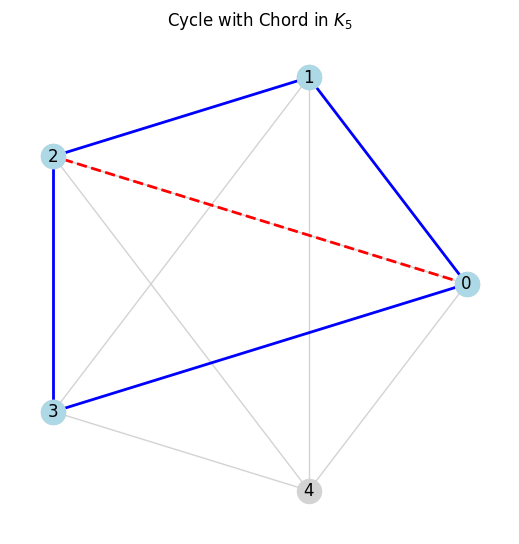

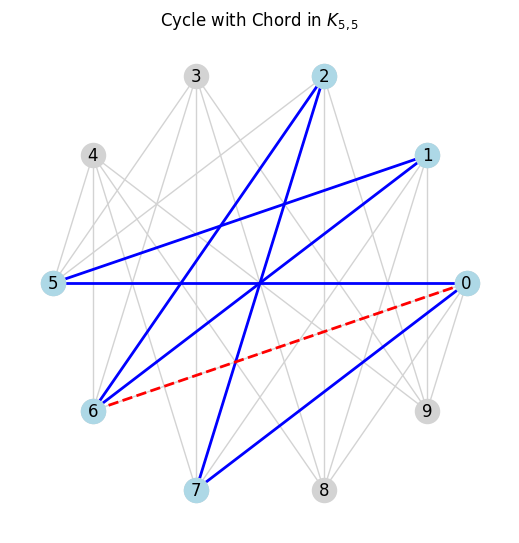

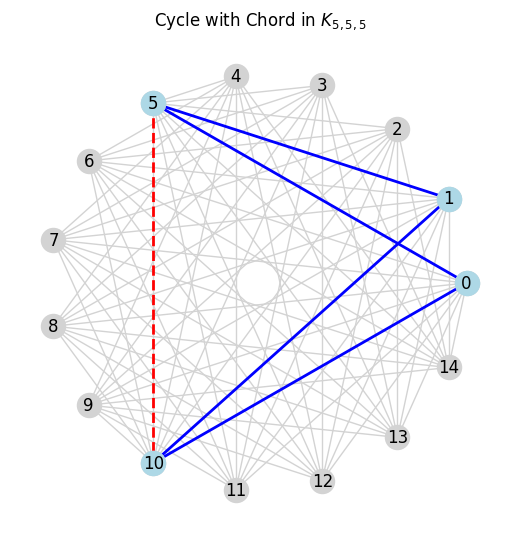

In [56]:
def draw_graph_with_cycle_and_chord(G, title):
    cycle, chord = find_cycle_with_chord(G)
    plt.figure(figsize=(5, 5))
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightgray', edge_color='lightgray')
    nx.draw_networkx_nodes(G, pos, nodelist=cycle, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, edgelist=[(cycle[i], cycle[(i+1)%len(cycle)]) for i in range(len(cycle))], edge_color='blue', width=2)
    nx.draw_networkx_edges(G, pos, edgelist=[chord], edge_color='red', width=2, style='dashed')
    plt.title(title)
    plt.show()


n = 5
G = nx.complete_graph(n)
draw_graph_with_cycle_and_chord(G, f"Cycle with Chord in $K_{{{n}}}$")
H = nx.complete_bipartite_graph(n, n)
draw_graph_with_cycle_and_chord(H, f"Cycle with Chord in $K_{{{n}, {n}}}$")
I = nx.complete_multipartite_graph(n, n, n)
draw_graph_with_cycle_and_chord(I, f"Cycle with Chord in $K_{{{n}, {n}, {n}}}$")